<a href="https://colab.research.google.com/github/Domminique/Pytorch_audio_bird_species_identification/blob/main/Copy_of_audio_io_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Audio I/O

**Author**: [Moto Hira](moto@meta.com)_

This tutorial shows how to use TorchAudio's basic I/O API to load audio files
into PyTorch's Tensor object, and save Tensor objects to audio files.


In [ ]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

1.13.1+cu116
0.13.1+cu116


## Preparation

First, we import the modules and download the audio assets we use in this tutorial.

<div class="alert alert-info"><h4>Note</h4><p>When running this tutorial in Google Colab, install the required packages
   with the following:

   .. code::

      !pip install boto3</p></div>



In [ ]:
!pip install boto3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 61.0 MB/s eta 0:00:00


In [ ]:
import io
import os
import tarfile
import tempfile

import boto3
import matplotlib.pyplot as plt
import requests
from botocore import UNSIGNED
from botocore.config import Config
from IPython.display import Audio
from torchaudio.utils import download_asset

SAMPLE_GSM = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.gsm")
SAMPLE_WAV = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
SAMPLE_WAV_8000 = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")

  0%|          | 0.00/7.99k [00:00<?, ?B/s]

  0%|          | 0.00/106k [00:00<?, ?B/s]

  0%|          | 0.00/53.2k [00:00<?, ?B/s]

## Querying audio metadata

Function :py:func:`torchaudio.info` fetches audio metadata.
You can provide a path-like object or file-like object.




In [ ]:
metadata = torchaudio.info(SAMPLE_WAV)
print(metadata)

AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=16, encoding=PCM_S)


Where

-  ``sample_rate`` is the sampling rate of the audio
-  ``num_channels`` is the number of channels
-  ``num_frames`` is the number of frames per channel
-  ``bits_per_sample`` is bit depth
-  ``encoding`` is the sample coding format

``encoding`` can take on one of the following values:

-  ``"PCM_S"``: Signed integer linear PCM
-  ``"PCM_U"``: Unsigned integer linear PCM
-  ``"PCM_F"``: Floating point linear PCM
-  ``"FLAC"``: Flac, [Free Lossless Audio
   Codec](https://xiph.org/flac/)_
-  ``"ULAW"``: Mu-law,
   [[wikipedia](https://en.wikipedia.org/wiki/%CE%9C-law_algorithm)_]
-  ``"ALAW"``: A-law
   [[wikipedia](https://en.wikipedia.org/wiki/A-law_algorithm)_]
-  ``"MP3"`` : MP3, MPEG-1 Audio Layer III
-  ``"VORBIS"``: OGG Vorbis [[xiph.org](https://xiph.org/vorbis/)_]
-  ``"AMR_NB"``: Adaptive Multi-Rate
   [[wikipedia](https://en.wikipedia.org/wiki/Adaptive_Multi-Rate_audio_codec)_]
-  ``"AMR_WB"``: Adaptive Multi-Rate Wideband
   [[wikipedia](https://en.wikipedia.org/wiki/Adaptive_Multi-Rate_Wideband)_]
-  ``"OPUS"``: Opus [[opus-codec.org](https://opus-codec.org/)_]
-  ``"GSM"``: GSM-FR
   [[wikipedia](https://en.wikipedia.org/wiki/Full_Rate)_]
-  ``"HTK"``: Single channel 16-bit PCM
-  ``"UNKNOWN"`` None of above




**Note**

-  ``bits_per_sample`` can be ``0`` for formats with compression and/or
   variable bit rate (such as MP3).
-  ``num_frames`` can be ``0`` for GSM-FR format.




In [ ]:
metadata = torchaudio.info(SAMPLE_GSM)
print(metadata)

AudioMetaData(sample_rate=8000, num_frames=0, num_channels=1, bits_per_sample=0, encoding=GSM)


## Querying file-like object

:py:func:`torchaudio.info` works on file-like objects.




In [ ]:
url = "https://download.pytorch.org/torchaudio/tutorial-assets/steam-train-whistle-daniel_simon.wav"
with requests.get(url, stream=True) as response:
    metadata = torchaudio.info(response.raw)
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)


<div class="alert alert-info"><h4>Note</h4><p>When passing a file-like object, ``info`` does not read
   all of the underlying data; rather, it reads only a portion
   of the data from the beginning.
   Therefore, for a given audio format, it may not be able to retrieve the
   correct metadata, including the format itself. In such case, you
   can pass ``format`` argument to specify the format of the audio.</p></div>



## Loading audio data

To load audio data, you can use :py:func:`torchaudio.load`.

This function accepts a path-like object or file-like object as input.

The returned value is a tuple of waveform (``Tensor``) and sample rate
(``int``).

By default, the resulting tensor object has ``dtype=torch.float32`` and
its value range is ``[-1.0, 1.0]``.

For the list of supported format, please refer to [the torchaudio
documentation](https://pytorch.org/audio)_.




In [ ]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

In [ ]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)

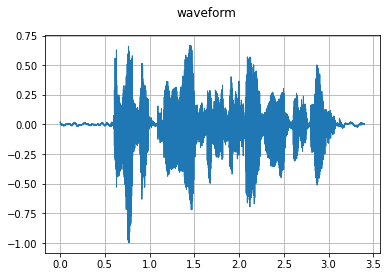

In [ ]:
plot_waveform(waveform, sample_rate)

In [ ]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show(block=False)

In [ ]:
plot_specgram(waveform, sample_rate)

In [ ]:
Audio(waveform.numpy()[0], rate=sample_rate)

## Loading from file-like object

The I/O functions support file-like objects.
This allows for fetching and decoding audio data from locations
within and beyond the local file system.
The following examples illustrate this.




In [ ]:
# Load audio data as HTTP request
url = "https://download.pytorch.org/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
with requests.get(url, stream=True) as response:
    waveform, sample_rate = torchaudio.load(response.raw)
plot_specgram(waveform, sample_rate, title="HTTP datasource")

In [ ]:
# Load audio from tar file
tar_path = download_asset("tutorial-assets/VOiCES_devkit.tar.gz")
tar_item = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
with tarfile.open(tar_path, mode="r") as tarfile_:
    fileobj = tarfile_.extractfile(tar_item)
    waveform, sample_rate = torchaudio.load(fileobj)
plot_specgram(waveform, sample_rate, title="TAR file")

In [ ]:
# Load audio from S3
bucket = "pytorch-tutorial-assets"
key = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
client = boto3.client("s3", config=Config(signature_version=UNSIGNED))
response = client.get_object(Bucket=bucket, Key=key)
waveform, sample_rate = torchaudio.load(response["Body"])
plot_specgram(waveform, sample_rate, title="From S3")

## Tips on slicing

Providing ``num_frames`` and ``frame_offset`` arguments restricts
decoding to the corresponding segment of the input.

The same result can be achieved using vanilla Tensor slicing,
(i.e. ``waveform[:, frame_offset:frame_offset+num_frames]``). However,
providing ``num_frames`` and ``frame_offset`` arguments is more
efficient.

This is because the function will end data acquisition and decoding
once it finishes decoding the requested frames. This is advantageous
when the audio data are transferred via network as the data transfer will
stop as soon as the necessary amount of data is fetched.

The following example illustrates this.




In [ ]:
# Illustration of two different decoding methods.
# The first one will fetch all the data and decode them, while
# the second one will stop fetching data once it completes decoding.
# The resulting waveforms are identical.

frame_offset, num_frames = 16000, 16000  # Fetch and decode the 1 - 2 seconds

url = "https://download.pytorch.org/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
print("Fetching all the data...")
with requests.get(url, stream=True) as response:
    waveform1, sample_rate1 = torchaudio.load(response.raw)
    waveform1 = waveform1[:, frame_offset : frame_offset + num_frames]
    print(f" - Fetched {response.raw.tell()} bytes")

print("Fetching until the requested frames are available...")
with requests.get(url, stream=True) as response:
    waveform2, sample_rate2 = torchaudio.load(response.raw, frame_offset=frame_offset, num_frames=num_frames)
    print(f" - Fetched {response.raw.tell()} bytes")

print("Checking the resulting waveform ... ", end="")
assert (waveform1 == waveform2).all()
print("matched!")

## Saving audio to file

To save audio data in formats interpretable by common applications,
you can use :py:func:`torchaudio.save`.

This function accepts a path-like object or file-like object.

When passing a file-like object, you also need to provide argument ``format``
so that the function knows which format it should use. In the
case of a path-like object, the function will infer the format from
the extension. If you are saving to a file without an extension, you need
to provide argument ``format``.

When saving WAV-formatted data, the default encoding for ``float32`` Tensor
is 32-bit floating-point PCM. You can provide arguments ``encoding`` and
``bits_per_sample`` to change this behavior. For example, to save data
in 16-bit signed integer PCM, you can do the following.

<div class="alert alert-info"><h4>Note</h4><p>Saving data in encodings with a lower bit depth reduces the
   resulting file size but also precision.</p></div>




In [ ]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

In [ ]:
def inspect_file(path):
    print("-" * 10)
    print("Source:", path)
    print("-" * 10)
    print(f" - File size: {os.path.getsize(path)} bytes")
    print(f" - {torchaudio.info(path)}")
    print()

Save without any encoding option.
The function will pick up the encoding which
the provided data fit



In [ ]:
with tempfile.TemporaryDirectory() as tempdir:
    path = f"{tempdir}/save_example_default.wav"
    torchaudio.save(path, waveform, sample_rate)
    inspect_file(path)

Save as 16-bit signed integer Linear PCM
The resulting file occupies half the storage but loses precision



In [ ]:
with tempfile.TemporaryDirectory() as tempdir:
    path = f"{tempdir}/save_example_PCM_S16.wav"
    torchaudio.save(path, waveform, sample_rate, encoding="PCM_S", bits_per_sample=16)
    inspect_file(path)

:py:func:`torchaudio.save` can also handle other formats.
To name a few:




In [ ]:
formats = [
    "flac",
    "vorbis",
    "sph",
    "amb",
    "amr-nb",
    "gsm",
]

In [ ]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV_8000)
with tempfile.TemporaryDirectory() as tempdir:
    for format in formats:
        path = f"{tempdir}/save_example.{format}"
        torchaudio.save(path, waveform, sample_rate, format=format)
        inspect_file(path)

## Saving to file-like object

Similar to the other I/O functions, you can save audio to file-like
objects. When saving to a file-like object, argument ``format`` is
required.




In [ ]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

# Saving to bytes buffer
buffer_ = io.BytesIO()
torchaudio.save(buffer_, waveform, sample_rate, format="wav")

buffer_.seek(0)
print(buffer_.read(16))